In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

The goal of this project is to develop a system that can look at images of handwritten cursive letters and accurately identify which letter each image represents. The customer wants a tool that can process many different handwritten samples, including different handwriting styles, and automatically recognize each letter the image is showing.

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

The dataset was provided as a zip file containing around 30 samples of cursive letter a through z with the folder seperated by student who wrote each letter and file name signifying the letter. The fact that the dataset is handwritten images will make recognition more challenging due to the natural variations in handwriting style.

In [5]:
import os
import zipfile
from pillow_heif import register_heif_opener
from PIL import Image
import cv2
import numpy as np
import pandas as pd
from pathlib import Path


ZIP_PATH = "images.zip"                
EXTRACT_PATH = "extracted_images"        
CONVERTED_PATH = "converted_images"       
IMAGE_SIZE = (250, 250)                  


os.makedirs(EXTRACT_PATH, exist_ok=True)
print("Extracting dataset from ZIP...")
with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
    zip_ref.extractall(EXTRACT_PATH)
print("Extraction complete.\n")

register_heif_opener()
os.makedirs(CONVERTED_PATH, exist_ok=True)

heic_files = []
for root, _, files in os.walk(EXTRACT_PATH):
    for f in files:
        if f.lower().endswith(".heic"):
            heic_files.append((root, f))

print(f"Found {len(heic_files)} HEIC files to convert.")
for root, file in heic_files:
    src = os.path.join(root, file)
    rel_dir = os.path.relpath(root, EXTRACT_PATH)
    target_dir = os.path.join(CONVERTED_PATH, rel_dir)
    os.makedirs(target_dir, exist_ok=True)

    target_path = os.path.join(target_dir, file.rsplit('.', 1)[0] + ".jpg")
    with Image.open(src) as img:
        img.convert("L").resize((250, 250)).save(target_path, "JPEG", quality=85, optimize=True)

Extracting dataset from ZIP...
Extraction complete.

Found 456 HEIC files to convert.


# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

After extracting the zip file, I explored the dataset and verified the number of samples per letter. Each letter had a varying amount as there were some duplicates of letters and each folder was formatted in a weird way, so most likely I will have to remove all subfolders and make it one big folder with each image named after the letter it is. I will also have to crop some images to just see the paper it is written on because some are very zoomed out, which will make it difficult to detect the image. I used graphs to display image count per folder, refitted images to 250 by 250, and graphed the mean grayscale value/average brightness. 

loaded 491 total images from 16 writers.



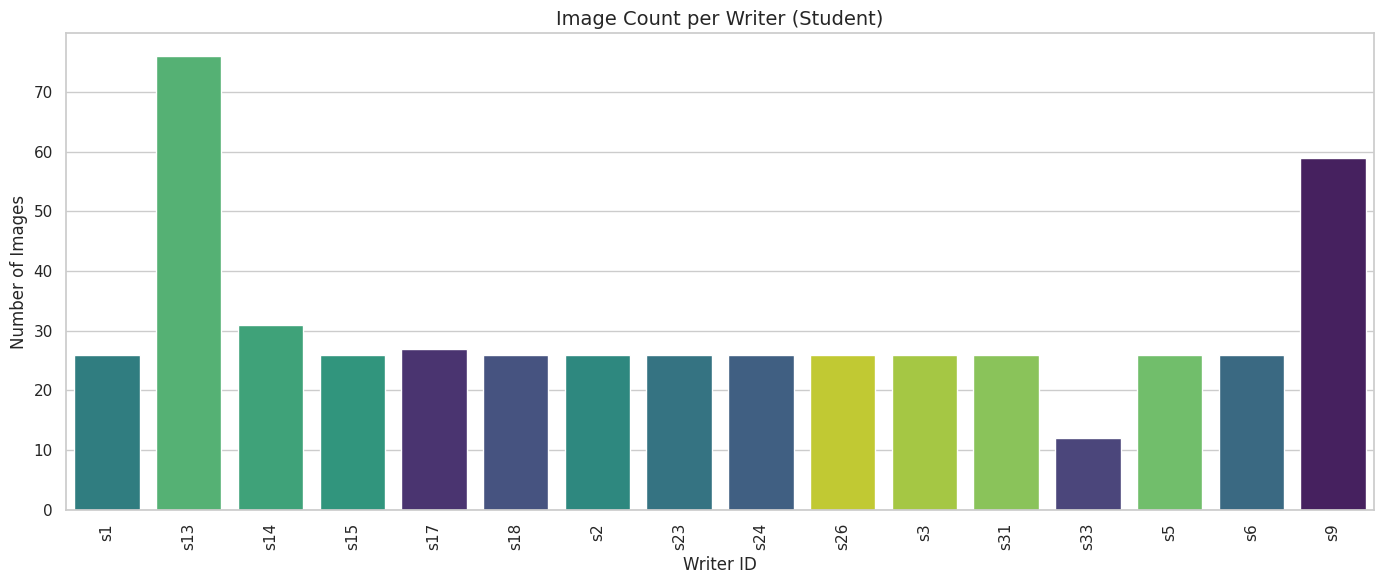

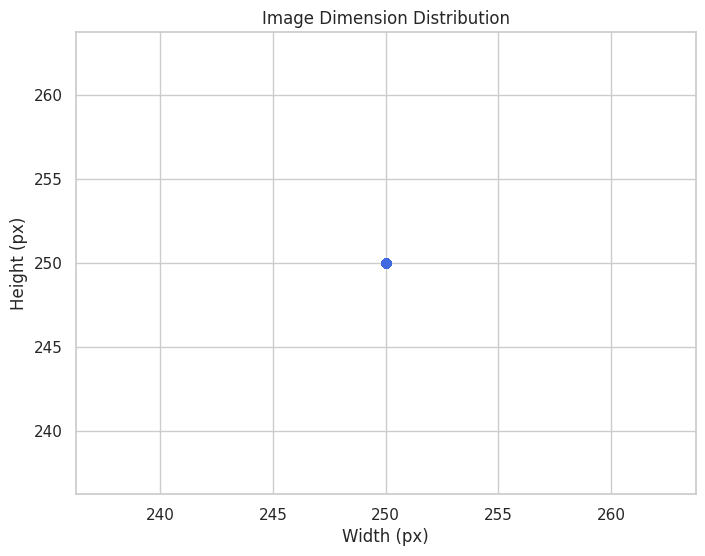

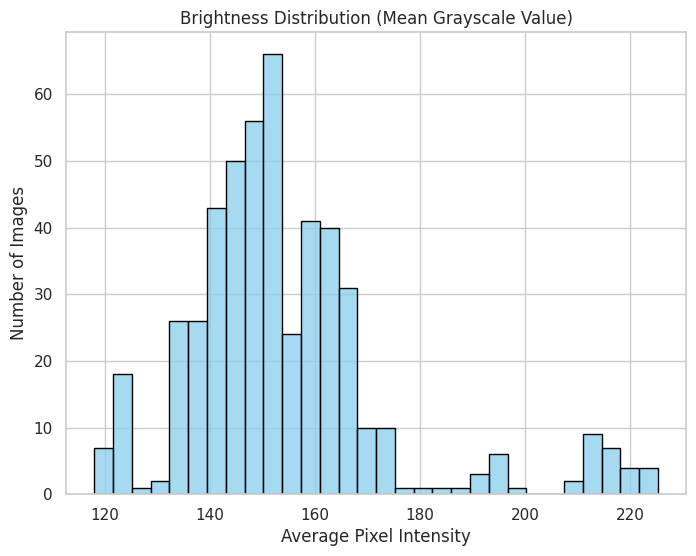

Displaying sample images from multiple writers


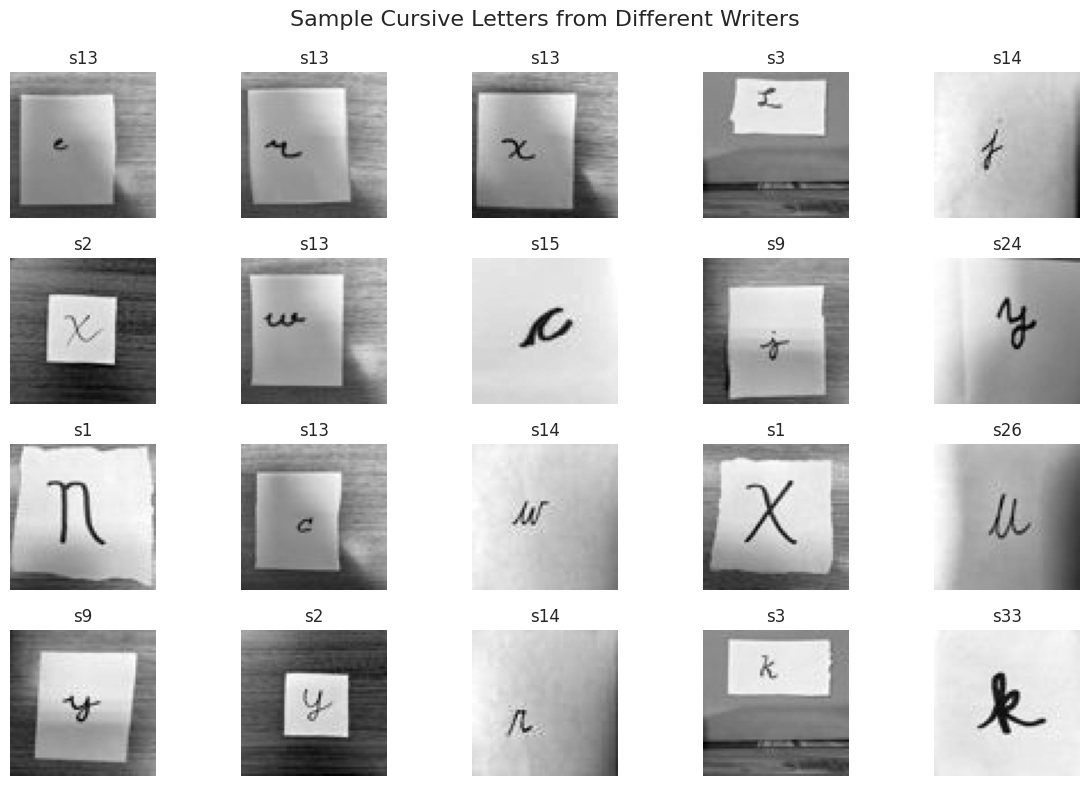

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


data = []
file_nums = []
meta_records = []

for root, _, files in os.walk(CONVERTED_PATH):
    for f in files:
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            path = os.path.join(root, f)
            file_num = os.path.basename(root).lower()

            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, IMAGE_SIZE)

            data.append(img)
            file_nums.append(file_num)
            meta_records.append({
                "filepath": path,
                "file_num": file_num,
                "width": img.shape[1],
                "height": img.shape[0],
                "brightness": np.mean(img)
            })

df = pd.DataFrame(meta_records)
data = np.array(data).reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 1) / 255.0
file_nums = np.array(file_nums)

print(f"loaded {len(data)} total images from {len(np.unique(file_nums))} folders.\n")

plt.figure(figsize=(14, 6))
sns.countplot(
    data=df,
    x="file_num",
    hue="file_num",
    order=sorted(df["file_num"].unique()),
    palette="viridis",
    legend=False
)
plt.title("Image Count per folder", fontsize=14)
plt.xlabel("Folder #")
plt.ylabel("Number of Images")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(df["brightness"], bins=30, color="skyblue", edgecolor="black")
plt.title("Brightness Distribution (Mean Grayscale Value)")
plt.xlabel("Average Pixel Intensity")
plt.ylabel("Number of Images")
plt.show()

print("Displaying sample images from multiple folders")
sample_df = df.sample(min(20, len(df)))
plt.figure(figsize=(12, 8))
for i, row in enumerate(sample_df.itertuples()):
    img = cv2.imread(row.filepath, cv2.IMREAD_GRAYSCALE)
    plt.subplot(4, 5, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(row.file_num)
    plt.axis("off")
plt.suptitle("Sample Cursive Letters from Different Folders", fontsize=16)
plt.tight_layout()
plt.show()

# 4.Prepare the Data


Apply any data transformations and explain what and why


In this step, I prepared the handwritten cursive letter images for modeling. I encoded each folder to numerical values starting at 0 to treat each writer like a different class. I normalized the pixels in the image to be from 0 to 1 instead of 0 to 255. Then I split the data into 80% training data and 20% testing data.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

encoder = LabelEncoder()
file_nums_encoded = encoder.fit_transform(file_nums)

X_train, X_test, y_train, y_test = train_test_split(
    data, file_nums_encoded, test_size=0.2, random_state=42, stratify=file_nums_encoded
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Unique folders: {len(encoder.classes_)}")
print(f"Folder #: {encoder.classes_}\n")

np.savez_compressed(
    "cursive_dataset_splits_80_20.npz",
    X_train=X_train, X_test=X_test,
    y_train=y_train, y_test=y_test
)

# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 


# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken


# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 
